## The BandCamp Tour Planner 
### How Independent Bands Can Use Data to Plan Their Next Tour More Effectively

Gavin Leeper

For independent bands without booking agents, booking tours is a challenging and lengthy process. Even booking one show can involve a saga of research finding venues, trying to get contact info for bookers, reaching out, following up, and hopefully hearing back from one. From the other end, many venues are hesitant to take a gamble on out of towners when they could book dependable local acts instead, resulting in lost revenue on all sides from the risks. To address the risks, venues accept  often prefer to book known local acts paired with out of towners, but this is a tough scheduling issue that the bands have to solve on their own.   In view of how important both scheduling and (more importantly) band-band fit is to the process of booking shows, I decided to build a system that would recommend bands to each other so that they could play together and create a wonderful experience for each other, the venues they play at, and most importantly their fans. Here’s how I built this system using album purchase data scraped from Bandcamp. 

These two bands should play together. Skip to my Process Overview and Results section to find out why.

In [19]:
%%HTML
<iframe style="border: 0; width: 100%; height: 42px;" src="https://bandcamp.com/EmbeddedPlayer/album=1772114228/size=small/bgcol=ffffff/linkcol=0687f5/transparent=true/" seamless><a href="http://floral1.bandcamp.com/album/floral-ep">Floral EP by Floral</a></iframe>

In [20]:
%%HTML
<iframe style="border: 0; width: 100%; height: 42px;" src="https://bandcamp.com/EmbeddedPlayer/album=1560218554/size=small/bgcol=ffffff/linkcol=0687f5/track=3580191616/transparent=true/" seamless><a href="http://vespersails.bandcamp.com/album/cheshire-king">Cheshire King by Vesper Sails</a></iframe>

## Booking Shows Is Easier With Friends

In the first week of April, I got to go on my first tour with my Oakland-based band, [Paper Void](https://papervoid.bandcamp.com/). It was a humble operation compared to a professional tour: two nights in Los Angeles, one in San Diego, one in Portland, and a last show at Bottom of The Hill back in San Francisco. We were able to crash with our families the entire time and roll down highway 5 in a bus that our friends happened to own. We all have day jobs back here, so we didn't need to keep to a super tight budget. We did alright for our first tour  - we didn’t even lose that much money!

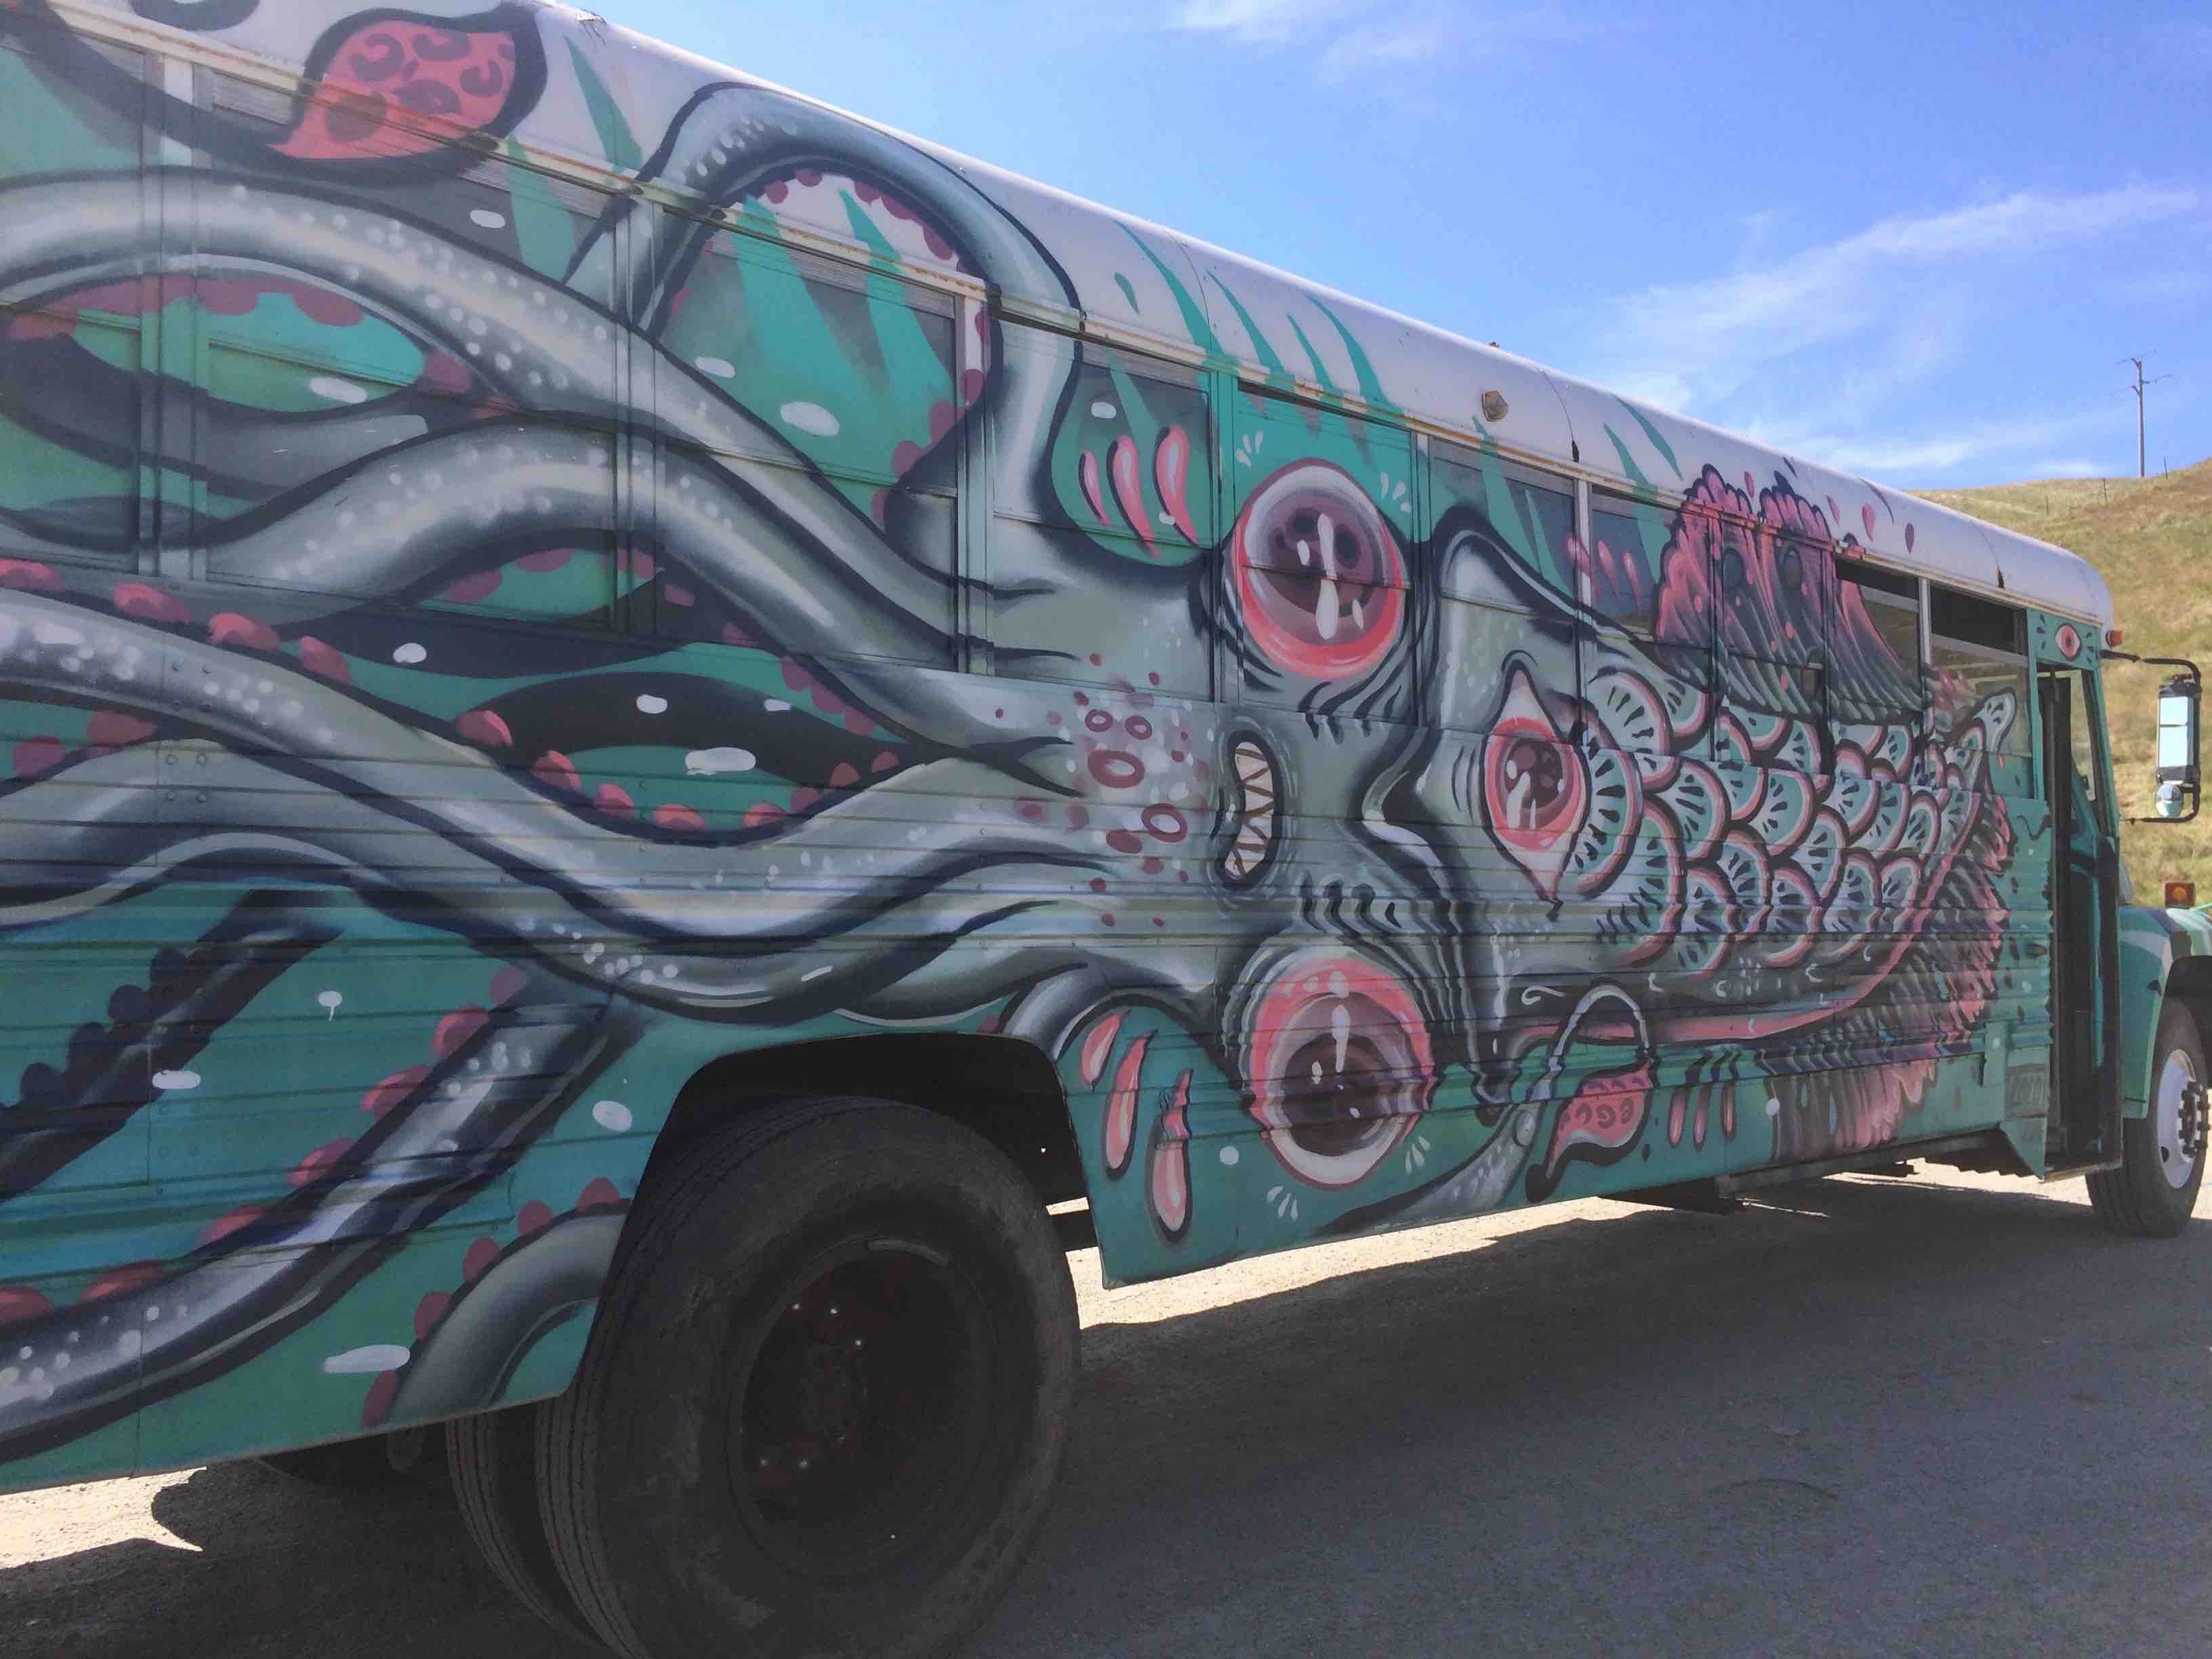

In [6]:
from IPython.display import Image
from IPython.core.display import HTML 
PATH = "/Users/Gavin/Documents/R_Coding_Materials/Signal/Projects/Bandcamp/"
Image(filename ="./Squidship_Very_Small.jpg")

Our trusty tour vessel, The Squidship. Painted by [Lauren YS](https://www.instagram.com/lolo.ys/?hl=en). It broke down right when we got back to Oakland. RIP.

Real tours in industry, I am told, are much more challenging than ours for everyone but the most popular acts. I’ve heard war stories from friends about hitting 42 cities in 45 days with 7 people and their gear crammed into one van, getting one motel room for the entire band each night, $10 per diems that had them eating potato chips for lunch, or getting all their gear stolen. To quote my friend Kyle, "You come back from tour completely drained and demoralized, and yet somehow excited to do the whole thing again the next day." With this little taste of the "road life" and booking our mini-tour, I noticed how important networking is:  

When independent bands are trying to get booked at venues, especially away from home, it helps to have friends who are a local band and know the scene. It helps even more if those friends mesh with you musically, and you can approach the venue with a cohesive ticket for the night you are asking about.

Take our show in Portland, for example. Instead of diving into the lengthy research process described above, one of our singers Hannah, who is from Oregon, reached out to a childhood friend in a local band called Space Shark, and we were able to book our gig at Kelly's Olmpian faster than you could say [polymetre](https://en.wikipedia.org/wiki/Metre_(music).

By contrast, even reaching out with friends in a local LA band, we indeed did have to go through the email saga (partially since there are so many bands in LA and getting gigs is very competitive) and we ended up having to plan a house party with them instead. That party was really great too, but likely resulted in less revenue and less exposure than a venue show would have. The economics of it all need to add up a bit better when you are planning a real professional tour. As you can imagine, the sheer difficulty of planning a good tour is why there are professionals who often manage bands' tours for them, and their services can really be worth it even at smaller scales.

## Don't Have Friends? Find Similar Bands

When they don't have friends in the area where they want to play, how should bands figure out who to play with or where to play? Or perhaps an even better question, how should smaller bands figure out what cities to play in in the first place? If there are no bands like you in the area in terms of sound and size of following, and no venues that tend to host music like yours, does it make sense to skip a city entirely? No one wants drive out to a faraway college town just to play for 5 people and get little exposure or money for their efforts.

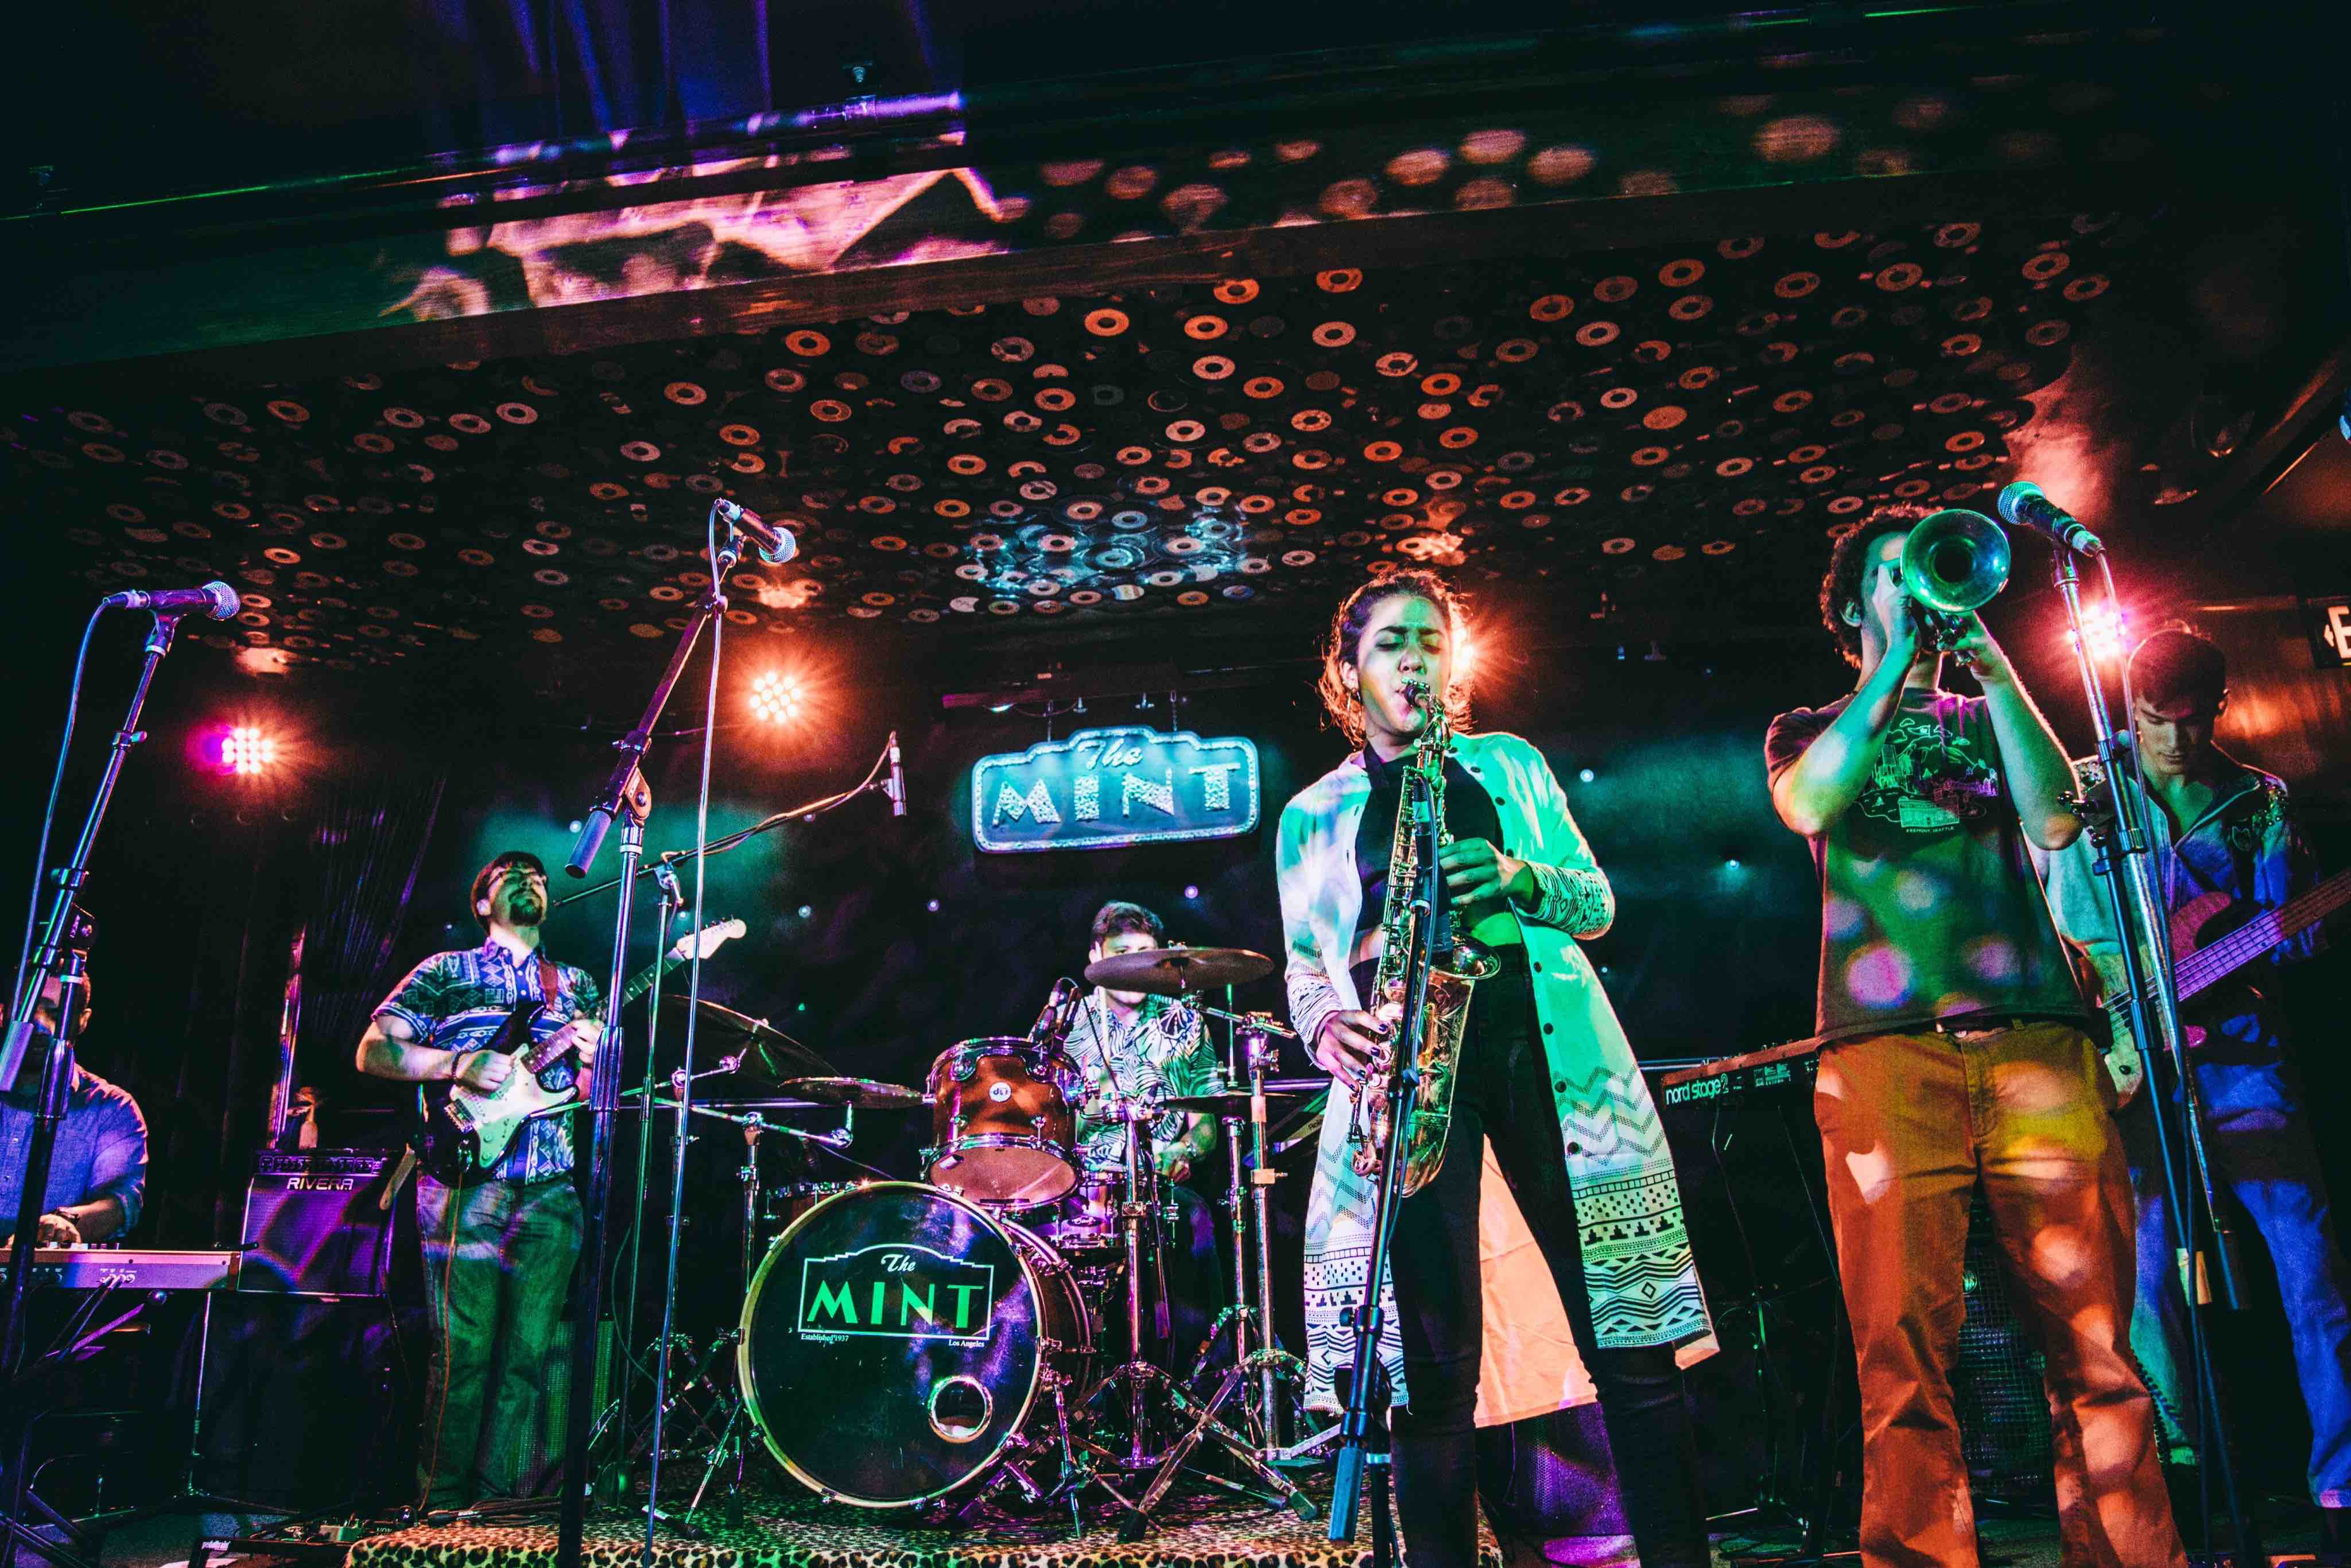

In [5]:
PATH = "/Users/Gavin/Documents/R_Coding_Materials/Signal/Projects/Bandcamp/"
Image(filename = PATH + "TheMint_Very_Small.jpg")

Paper Void at The Mint in Los Angeles. Photo credit: [Karen Rosalie](https://www.instagram.com/karen.rosalie/)

It is with this in mind that I decided to work on what I call the Bandcamp Tour Planner.
My idea is to leverage data scraped from Bandcamp to recommend bands to each other that should play together. I ultimately want to build this out for multiple cities. As a first step toward a tour planning tool, however, I decided to look at the smaller question of "What local Bay Area bands should play with each other next?"

## Process Overview

There are a few ways to attack this question. I decided to look at number of overlapping fans, i.e. fans who bought one or more albums from both Artist A and Artist B, as a way to measure those artists' similarity to each other.

I scraped data from album pages for some artists I know of in the Bay Area and then from some of best selling albums on Bandcamp with the tags San Francisco, Oakland, or Bay Area, resulting in a dataset of 362 distinct bands and about 24000 users who bought their albums. I rearranged this data into a matrix with all the artists names along the rows as well as the columns. Here, a given entry represents how many fans the pair of artists at that row and column share, and the number of fans an artist shares with themselves is simply their total number of fans. As you can imagine, about 95% of its values are zero.

In [6]:
#import packages for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn.preprocessing import scale
from scipy.spatial import distance
from sklearn.decomposition import FactorAnalysis
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

fans = pd.read_csv('fans.csv', index_col=0)

#convert artist ID and album ID into integers
fans.a_id = [int(v) for v in  fans.a_id.values]
fans.alb_id = [int(v) for v in  fans.alb_id.values]

In [7]:
art_name_df = pd.read_csv('BandNames.csv',index_col=0)

#drop artists without ID numbers
art_name_df = art_name_df.loc[~art_name_df.a_id.isnull(),:]

#convert artist ID into integer
art_name_df.a_id = [int(v) for v in  art_name_df.a_id.values]
art_name_df = art_name_df.drop_duplicates('a_name')
#creating names index for artist-fan matrix

ser = pd.Series(art_name_df.a_name.values, index = art_name_df.a_id.values)

a_ids = pd.Series(fans.a_id.unique())

a_name_ind = []

#loop through artist id values
#if there is an artist name stored for an artist id,
#add that name to the index. otherwise, add the artis id itself
for a in a_ids.values:
    if a in ser:
        a_name_ind.append(ser[a])
    else:
        a_name_ind.append(a)

artist_fan_mat = pd.DataFrame(0, index = a_ids, columns=fans.fan_name.unique())

#filling artist_fan_mat
def af_fill(row):
    artist_fan_mat.loc[row['a_id'],row['fan_name']] = 1
    
fans.apply(af_fill, axis=1)
artist_fan_mat.index = a_name_ind
overlap_fans = np.dot(artist_fan_mat,artist_fan_mat.transpose())
overlap_fans = pd.DataFrame(overlap_fans, index=artist_fan_mat.index, columns=artist_fan_mat.index)

overlap_fans.head(10)

,Deathbomb Arc,Hannah Moriah,bunnysuit,the seOUL avengeR,Pity Party,Mentality,White Fuzzy Bloodbath,No Statik,BUSTED OUTLOOK,PORCH,...,The Fancy Dan Band,The Luna Sequence,Club Lonely,Vin Sol,King Woman,Donovan Quinn,wait what,devon gundry,Nu Vintage,Cherushii
Deathbomb Arc,28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
Hannah Moriah,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bunnysuit,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
the seOUL avengeR,0,0,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Pity Party,0,0,0,0,13,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Mentality,0,0,0,0,0,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
White Fuzzy Bloodbath,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
No Statik,0,0,0,0,0,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
BUSTED OUTLOOK,0,0,0,0,1,1,0,0,62,0,...,0,0,0,0,0,0,0,0,0,0
PORCH,0,0,0,0,0,0,0,0,0,36,...,0,0,0,0,1,0,0,0,0,0


In [18]:
sum(overlap_fans.apply(pd.value_counts).loc[0,:])/(369*369)

0.95213754305564735

From there, I used data science methods that I'll describe in more detail in an upcoming technical post to calculate a similarity metric between artists. Here, I processed the data using Factor Analysis and then used a common metric called cosine similarity, which can range from -1 to 1. Each band is perfectly similar to itself, so the diagonal of the matrix is all ones.

In [67]:
#run FA on the number of overlap users
fa = FactorAnalysis(n_components = 7)
fa.fit(overlap_fans)

fa_result_df = pd.DataFrame(fa.components_.transpose(), index = overlap_fans.index)

#generate sparse matrix of fa results
fan_mat_sparse = sparse.csr_matrix(fa_result_df)
cos_sim = cosine_similarity(fan_mat_sparse)
fa_cos_sim = pd.DataFrame(cos_sim, index = fa_result_df.index, columns= fa_result_df.index)

fa_cos_sim1.head(10)

,Deathbomb Arc,Hannah Moriah,bunnysuit,the seOUL avengeR,Pity Party,Mentality,White Fuzzy Bloodbath,No Statik,BUSTED OUTLOOK,PORCH,...,The Fancy Dan Band,The Luna Sequence,Club Lonely,Vin Sol,King Woman,Donovan Quinn,wait what,devon gundry,Nu Vintage,Cherushii
Deathbomb Arc,1.000000,0.428335,-0.404198,-0.404198,0.402929,-0.394181,-0.437989,-0.097041,0.457153,0.071247,...,-0.404197,0.322863,0.426397,-0.368081,0.407378,-0.350800,0.418086,-0.124907,-0.313398,0.502653
Hannah Moriah,0.428335,1.000000,-0.369374,-0.369375,0.994854,-0.288633,-0.380209,-0.023196,0.942410,0.276279,...,-0.369373,0.698557,-0.069832,-0.365077,0.741755,-0.318698,0.311409,-0.059445,-0.250366,0.770729
bunnysuit,-0.404198,-0.369374,1.000000,1.000000,-0.290726,0.994411,0.991244,-0.478569,-0.599249,-0.497315,...,1.000000,-0.860376,-0.512402,0.994575,-0.717180,0.985921,-0.614993,-0.192663,0.291473,-0.490494
the seOUL avengeR,-0.404198,-0.369375,1.000000,1.000000,-0.290726,0.994411,0.991245,-0.478570,-0.599250,-0.497313,...,1.000000,-0.860376,-0.512402,0.994575,-0.717179,0.985921,-0.614991,-0.192664,0.291472,-0.490495
Pity Party,0.402929,0.994854,-0.290726,-0.290726,1.000000,-0.210269,-0.295988,-0.084409,0.912367,0.289203,...,-0.290725,0.651775,-0.136345,-0.289785,0.725736,-0.231587,0.304182,-0.087953,-0.250768,0.734163
Mentality,-0.394181,-0.288633,0.994411,0.994411,-0.210269,1.000000,0.979671,-0.441732,-0.524296,-0.514587,...,0.994411,-0.824501,-0.524931,0.991525,-0.686853,0.980479,-0.642744,-0.165951,0.264864,-0.431863
White Fuzzy Bloodbath,-0.437989,-0.380209,0.991244,0.991245,-0.295988,0.979671,1.000000,-0.519661,-0.614610,-0.389725,...,0.991244,-0.825497,-0.584764,0.974542,-0.664653,0.988613,-0.541117,-0.246504,0.295508,-0.547078
No Statik,-0.097041,-0.023196,-0.478569,-0.478570,-0.084409,-0.441732,-0.519661,1.000000,0.193332,-0.041742,...,-0.478568,0.299817,0.356438,-0.451878,0.068284,-0.512937,-0.176508,0.645505,-0.350566,0.063809
BUSTED OUTLOOK,0.457153,0.942410,-0.599249,-0.599250,0.912367,-0.524296,-0.614610,0.193332,1.000000,0.326240,...,-0.599248,0.837428,0.144177,-0.592520,0.815873,-0.550106,0.428165,0.005986,-0.422090,0.842801
PORCH,0.071247,0.276279,-0.497315,-0.497313,0.289203,-0.514587,-0.389725,-0.041742,0.326240,1.000000,...,-0.497319,0.647978,-0.132968,-0.546642,0.802354,-0.377417,0.844629,-0.067051,-0.344198,0.062043


## Results

Once we have this similarity metric calculated between all of the pairs of bands, we can make recommendations for a given band to play with simply by returning the bands with the highest scores. Even in this relatively small dataset and simple method, I keyed into some relationships that make sense. Let's look at the top 10 similar bands for my friend's band Floral.

In [26]:
%%HTML 
<iframe style="border: 0; width: 100%; height: 120px;" src="https://bandcamp.com/EmbeddedPlayer/album=1772114228/size=large/bgcol=ffffff/linkcol=0687f5/tracklist=false/artwork=small/transparent=true/" seamless><a href="http://floral1.bandcamp.com/album/floral-ep">Floral EP by Floral</a></iframe>

In [21]:
df['Floral'].sort_values(ascending=False).head(11)

Floral                  1.000000
calculator              0.955080
Feed Me Jack            0.936054
Enigma                  0.894313
The Classical           0.879036
fruits &amp; flowers    0.856839
Ridgewell               0.830369
Michael manring         0.825460
Vesper Sails            0.813798
GuMMyBeAR               0.790657
TOPR                    0.778745
Name: Floral, dtype: float64

Though there are definitely some bands in here that wouldn't be a good fit with Floral at a show (for example Ridgewell and TOPR are more hip-hop beatmaker types), some others that made the top 10 would actually work quite well. From this list, Floral could consider reaching out to Vesper Sails and Feed Me Jack (though FMJ sadly broke up last year) for their next Bay Area show. These bands all fit into that math rock, guitar geek type of aesthetic that I, for one, have been really into lately.

In [21]:
%%HTML
<iframe style="border: 0; width: 100%; height: 42px;" src="https://bandcamp.com/EmbeddedPlayer/album=1560218554/size=small/bgcol=ffffff/linkcol=0687f5/track=3580191616/transparent=true/" seamless><a href="http://vespersails.bandcamp.com/album/cheshire-king">Cheshire King by Vesper Sails</a></iframe>

In [29]:
%%HTML
<iframe style="border: 0; width: 100%; height: 42px;" src="http://bandcamp.com/EmbeddedPlayer/album=3857343499/size=small/bgcol=ffffff/linkcol=0687f5/track=4011668779/transparent=true/" seamless><a href="http://feedmejack.com/album/ultra-ego">Ultra Ego by Feed Me Jack</a></iframe>

The top 10 similar bands for Tycho here also have noise, but some nice connections.

In [30]:
%%HTML
<iframe style="border: 0; width: 100%; height: 120px;" src="https://bandcamp.com/EmbeddedPlayer/album=834375136/size=large/bgcol=ffffff/linkcol=0687f5/tracklist=false/artwork=small/transparent=true/" seamless><a href="http://tycho.bandcamp.com/album/epoch">Epoch by Tycho</a></iframe>

In [22]:
df['Tycho'].sort_values(ascending=False).head(11)

Tycho                  1.000000
The Singing Limbs      0.992939
Marc Kate              0.992939
Christopher Willits    0.987425
Dimond Saints          0.951664
HUG Records            0.946621
SEENMR                 0.933670
Deathbomb Arc          0.907330
Young God              0.890294
Paris DJs              0.880626
Drumspyder             0.856820
Name: Tycho, dtype: float64

It's good to see, for example, Christopher Willits come up on this list since he and Tycho are frequent collaborators, have similar sounds, and indeed are both signed to the independent record label Ghostly International. 

In [31]:
%%HTML
<iframe style="border: 0; width: 100%; height: 42px;" src="http://bandcamp.com/EmbeddedPlayer/album=3820368810/size=small/bgcol=ffffff/linkcol=0687f5/transparent=true/" seamless><a href="http://shop.christopherwillits.com/album/opening">OPENING by Christopher Willits</a></iframe>

Two smaller local acts here that Tycho could consider for openers next time he plays in the Bay could include Young God or Marc Kate.

In [32]:
%%HTML
<iframe style="border: 0; width: 100%; height: 42px;" src="https://bandcamp.com/EmbeddedPlayer/album=1114604542/size=small/bgcol=ffffff/linkcol=0687f5/transparent=true/" seamless><a href="http://iantaggart.bandcamp.com/album/krwu-instrumentals">KRWU Instrumentals by Young God</a></iframe>

In [33]:
%%HTML
<iframe style="border: 0; width: 100%; height: 42px;" src="https://bandcamp.com/EmbeddedPlayer/album=2602726938/size=small/bgcol=ffffff/linkcol=0687f5/transparent=true/" seamless><a href="http://failingforms.bandcamp.com/album/despairer">Despairer by Marc Kate</a></iframe>

Of course, I couldn't do this without being curious about results for my band.

In [55]:
%%HTML
<iframe style="border: 0; width: 100%; height: 120px;" src="https://bandcamp.com/EmbeddedPlayer/album=3101358495/size=large/bgcol=ffffff/linkcol=0687f5/tracklist=false/artwork=small/transparent=true/" seamless><a href="http://papervoid.bandcamp.com/album/i-n-c-r-e-m-e-n-t-s">I N C R E M E N T S by Paper Void</a></iframe>

In [23]:
df['Paper Void'].sort_values(ascending=False).head(11)

Paper Void            1.000000
No Vacation           0.949340
The Nite Owl Diner    0.946255
Summer Peaks          0.925386
Big Tree              0.901477
Nackt                 0.884533
Acid Ghost            0.880456
Projekt Records       0.866929
Signal Flow 2017      0.861429
Dre Genevieve         0.861124
Daemon Hatfield       0.858900
Name: Paper Void, dtype: float64

In the data I collected here, there weren't really that many other Jazz/R&B/Nu-Soul bands available to recommend so not much would have come up if we had just looked for similar tags. In terms of fans that bought both our albums though, I could see it making sense for us to share a bill with Summer Peaks or Big Tree at some point. I think their sounds aren't terribly similar to ours per se, but they might be complimentary in building out a good overall show. I'd be curious to see what results a larger dataset might turn up for us.

In [54]:
%%HTML
<iframe style="border: 0; width: 100%; height: 42px;" src="https://bandcamp.com/EmbeddedPlayer/album=1707375036/size=small/bgcol=ffffff/linkcol=0687f5/transparent=true/" seamless><a href="http://summerpeaks.bandcamp.com/album/color-in-the-shade">Color in the Shade by Summer Peaks</a></iframe>

In [53]:
%%HTML
<iframe style="border: 0; width: 100%; height: 42px;" src="https://bandcamp.com/EmbeddedPlayer/track=3308508525/size=small/bgcol=ffffff/linkcol=0687f5/transparent=true/" seamless><a href="http://bigtree.bandcamp.com/track/raise-the-flag">Raise the Flag by Big Tree</a></iframe>

We can then visualize these relationships of similarity more generally by building a social graph with [Networkx](https://networkx.readthedocs.io/en/stable/overview.html) and exporting the result as .gexf for visualization in [Gephi](https://gephi.org/). Here, node size is determined by how connected a given band is to other bands in the network. The cosine similarity between two bands serves as the weight of their connection. The color is determined by a statistic called modularity class, which essentially seeks to organize the nodes into different clusters. For this graph plot, I only kept the 10 strongest connections from each node, and the node size is determined by how many times a node is connected to and how strong those connections are. 

We can see some of the band clusters that we found above. Floral is, indeed, close to Feed Me Jack, Tycho is close to Christopher Willits, and we're close to Summer Peaks. 

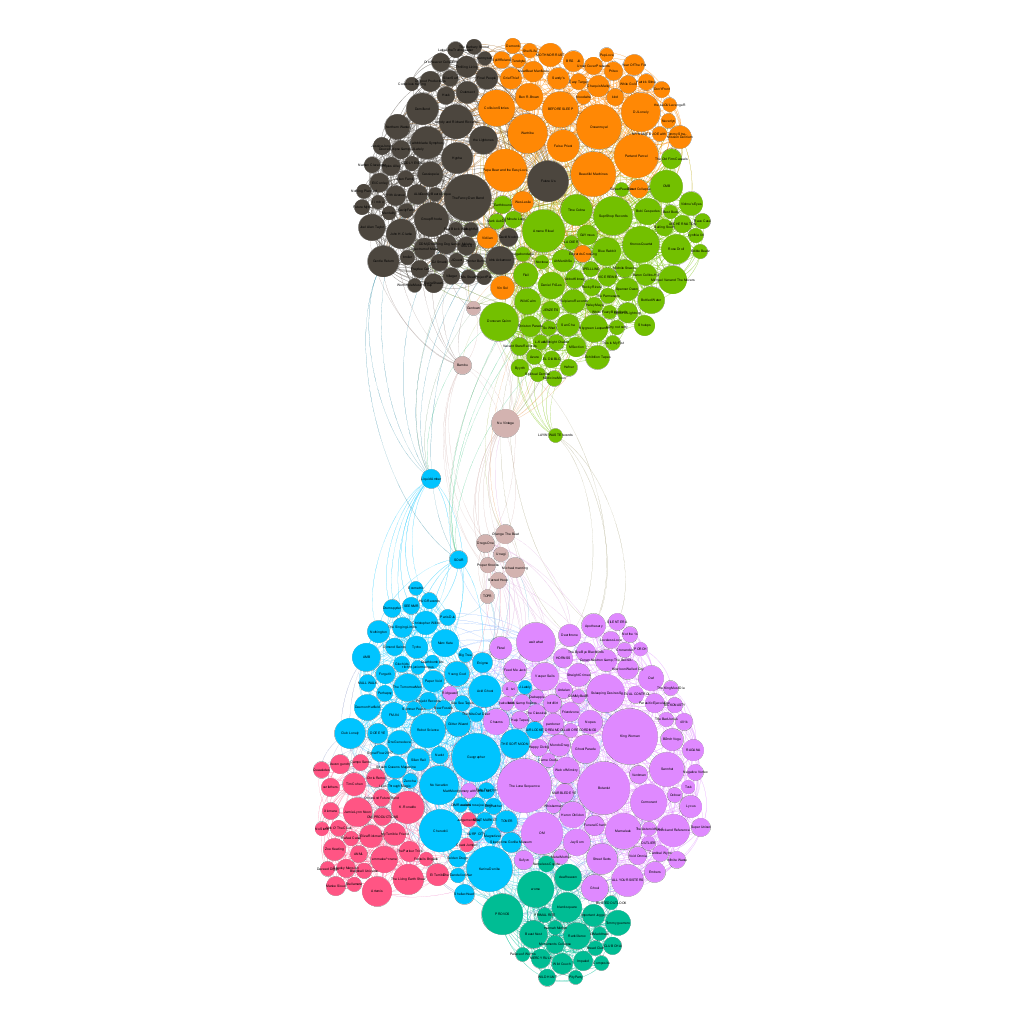

In [65]:
Image(filename = PATH + "NetworkGraph41717.png")

If you'd like to zoom in to see more details, you can do so by downloading the pdf [here](https://app.box.com/s/2f2h6rht58vhepnp7gwzpmjcrs4adgor).

## Going Forward

In the coming months, I hope to build this tool out such that a band can put their Bandcamp URL in and select a city they want to play in, and it will return the 10 most relevant bands for them to reach out to. I also intend to incorporate similar total size of following, either from total Bandcamp followers or from something like Facebook "likes" or Soundcloud followers. An even better tool might simply email the band whenever a similar act is playing in one of the cities they are tracking à la Bandisintown. 

Going by number of overlapping album purchasers is really only a start. This approach addresses the question a bit more robustly than shared tags, for example, since ultimately, we're looking for appeal to similar fan bases. However, if there's too much overlap of fan bases, it might not be optimal to book the bands together. That is, if Artist A and Artist B have too strongly overlapping of fan bases, you don't really get many extra people at the show by booking both of them instead of just one. This is really important to venues, whose economic goal is ultimately to sell their whole club out every night of the week. In future iterations, I intend to experiment with different metrics of similarity. 

Another next step could involve integrating Songkick data about what artists have played at what venues and also recommending venues to bands that other bands similar to them have played at in the past. On the venue side, if venues could be convinced to share their sales information, this tool could provide a prediction for the number of tickets a given bill of artists on a given night can be expected to sell (since the same bill would likely draw less people on a Tuesday night, for example, than a Friday). As I refine this tool and make it available online, I hope it will help bands book more great shows, and successful tours.